# Imports and data

In [92]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from scipy.stats import ttest_rel

In [89]:
data = pd.read_csv('data/st.csv')
# data.head()
data.describe()

,Price,Year,Mileage,Distance,Private,Generation
count,163.000000,163.000000,163.000000,163.000000,163.000000,163.000000
mean,8514.147239,2015.852761,62636.717791,170.742331,0.331288,7.073620
std,2330.041284,1.306362,24012.078352,65.825957,0.472127,0.261956
min,3030.000000,2014.000000,19000.000000,7.000000,0.000000,7.000000
25%,6797.000000,2015.000000,44500.000000,135.500000,0.000000,7.000000
50%,8500.000000,2016.000000,60600.000000,167.000000,0.000000,7.000000
75%,9892.500000,2017.000000,76177.000000,202.000000,1.000000,7.000000
max,14995.000000,2020.000000,164530.000000,357.000000,1.000000,8.000000


# Graphs

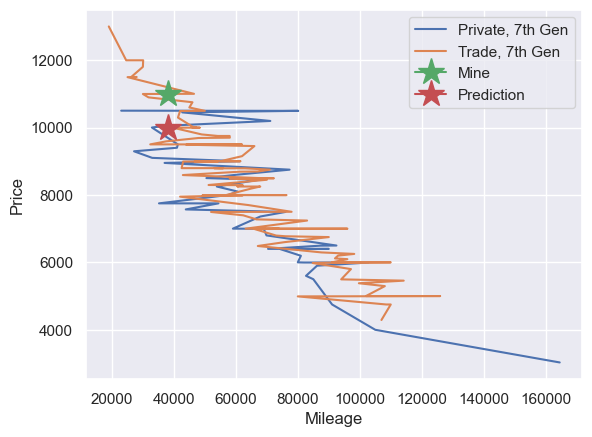

In [90]:
private_gen7_data = data[(data['Private'] == 1) & (data['Generation'] == 7)]
trade_gen7_data = data[(data['Private'] == 0) & (data['Generation'] == 7)]

y_private = private_gen7_data['Price']
y_trade = trade_gen7_data['Price']

x2p = private_gen7_data['Mileage']
x2t = trade_gen7_data['Mileage']

plt.plot(x2p, y_private, label='Private, 7th Gen')
plt.plot(x2t, y_trade, label='Trade, 7th Gen')
plt.plot(38000, 10995, '*-', markersize=20, label='Mine')
plt.plot(38000, 9999, '*-', markersize=20, label="Prediction")

plt.xlabel('Mileage')
plt.ylabel('Price')
plt.legend()

plt.show()

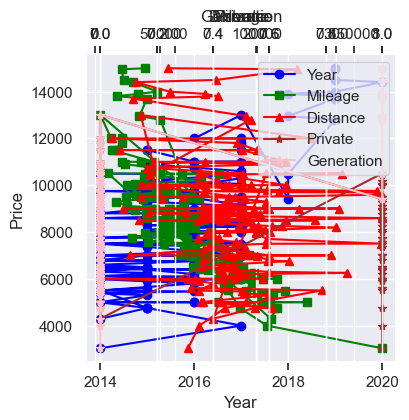

In [93]:
y = data['Price']
x1 = data['Year']
x2 = data['Mileage']
x3 = data['Distance']
x4 = data['Private']
x5 = data['Generation']

fig, ax1 = plt.subplots(figsize=(4, 4))

ax1.plot(x1, y, 'o-', label='Year', color='blue')
ax1.set_ylabel('Price')
ax1.set_xlabel('Year')

ax2 = ax1.twiny()
ax2.plot(x2, y, 's-', label='Mileage', color='green')
ax2.set_xlabel('Mileage')

ax3 = ax1.twiny()
ax3.plot(x3, y, '^-', label='Distance', color='red')
ax3.set_xlabel('Distance')

ax4 = ax1.twiny()
ax4.plot(x4, y, '*-', label='Private', color='brown')
ax4.set_xlabel('Private')

ax5 = ax1.twiny()
ax5.plot(x5, y, '*-', label='Generation', color='pink')
ax5.set_xlabel('Generation')

fig.legend(loc='upper right', bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes)

plt.show()

# Modelling

In [94]:
X = data.drop(['Price'], axis=1).copy()
y = data['Price'].copy()

mine = pd.DataFrame({
    'Year': [2017],
    'Mileage': [38000],
    'Distance': [1],
    'Private': [1],
    'Generation': [7]
})

In [95]:
variables = data[['Year', 'Mileage', 'Distance', 'Private', 'Generation']]
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
vif["features"] = variables.columns
vif

,VIF,features
0,1013.143048,Year
1,8.317946,Mileage
2,8.217171,Distance
3,1.822719,Private
4,960.102784,Generation


## No split

In [96]:
model_lr = LinearRegression()
model_lr.fit(X,y)
p_lr = model_lr.predict(mine).astype(int)
model_lr_summary = pd.DataFrame(X.columns.values, columns=['Features'])
model_lr_summary['Weights'] = model_lr.coef_

model_dtr = DecisionTreeRegressor()
model_dtr.fit(X,y)
p_dtr = model_dtr.predict(mine).astype(int)

model_rfr = RandomForestRegressor()
model_rfr.fit(X,y)
p_rfr = model_rfr.predict(mine).astype(int)

model_gbr = GradientBoostingRegressor(random_state=42)
model_gbr.fit(X,y)
p_gbr = model_gbr.predict(mine).astype(int)

model_xgb = XGBRegressor(random_state=42)
model_xgb.fit(X,y)
p_xgb = model_xgb.predict(mine).astype(int)

print(f'Linear:         £{p_lr[0]}')
print(f'Decision Tree:  £{p_dtr[0]}')
print(f'Random Forest:  £{p_rfr[0]}')
print(f'Gradient Boost: £{p_gbr[0]}')
print(f'XGB Boost:      £{p_xgb[0]}')
print(f'Mean:           £{int(np.mean([p_lr,p_dtr,p_rfr,p_gbr,p_xgb]))}')
print()
model_lr_summary

Linear:         £9952
Decision Tree:  £10050
Random Forest:  £10109
Gradient Boost: £10369
XGB Boost:      £10592
Mean:           £10214



,Features,Weights
0,Year,346.824903
1,Mileage,-0.066038
2,Distance,0.579833
3,Private,-397.593761
4,Generation,3024.158200


## Split

In [97]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_lr = LinearRegression()
model_lr.fit(X_train,y_train)
p_lr = model_lr.predict(X_test).astype(int)

model_dtr = DecisionTreeRegressor(random_state=42)
model_dtr.fit(X_train,y_train)
p_dtr = model_dtr.predict(X_test).astype(int)

model_rfr = RandomForestRegressor(random_state=42, n_estimators=100, criterion='absolute_error', max_depth=10, min_samples_split=5)
model_rfr.fit(X_train,y_train)
p_rfr = model_rfr.predict(X_test).astype(int)

model_gbr = GradientBoostingRegressor(random_state=42)
model_gbr.fit(X_train,y_train)
p_gbr = model_gbr.predict(X_test).astype(int)

model_xgb = XGBRegressor(random_state=42)
model_xgb.fit(X_train,y_train)
p_xgb = model_xgb.predict(X_test).astype(int)

mae_lr = mean_absolute_error(y_test, p_lr)
mae_dtr = mean_absolute_error(y_test, p_dtr)
mae_rfr = mean_absolute_error(y_test, p_rfr)
mae_gbr = mean_absolute_error(y_test, p_gbr)
mae_xgb = mean_absolute_error(y_test, p_xgb)

print(f'Random Forest:\t\t{p_rfr[:5]}\t\tMAE: {int(mae_rfr)}\tPrediction: £{int(model_rfr.predict(mine)[0])}')
print(f'Linear:\t\t\t{p_lr[:5]}\t\tMAE: {int(mae_lr)}\tPrediction: £{int(model_lr.predict(mine)[0])}')
print(f'Gradient Boost:\t\t{p_gbr[:5]}\t\tMAE: {int(mae_gbr)}\tPrediction: £{int(model_gbr.predict(mine)[0])}')
print(f'XGB Boost:\t\t{p_xgb[:5]}\t\tMAE: {int(mae_xgb)}\tPrediction: £{int(model_xgb.predict(mine)[0])}')
print(f'Decision Tree:\t\t{p_dtr[:5]}\t\tMAE: {int(mae_dtr)}\tPrediction: £{int(model_dtr.predict(mine)[0])}')

Random Forest:		[9986 7825 9299 6290 7506]		MAE: 568	Prediction: £10398
Linear:			[10120  8180  9449  6304  8154]		MAE: 602	Prediction: £9807
Gradient Boost:		[10575  7884  9207  6234  7280]		MAE: 684	Prediction: £10354
XGB Boost:		[10287  7174  9752  6379  7659]		MAE: 777	Prediction: £10275
Decision Tree:		[10490  7275  8995  6000  6795]		MAE: 827	Prediction: £10050


## Tuning and experimenting

### Cross validation

In [98]:
model_lr = LinearRegression()
scores = cross_val_score(model_lr, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
print(f"Linear\t\tCV MAE: {-scores.mean():.2f}")

model_rfr = RandomForestRegressor()
scores = cross_val_score(model_rfr, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
print(f"Random Forest\tCV MAE: {-scores.mean():.2f}")

model_dtr = DecisionTreeRegressor()
scores = cross_val_score(model_dtr, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
print(f"Decision Tree\tCV MAE: {-scores.mean():.2f}")

Linear		CV MAE: 657.32
Random Forest	CV MAE: 788.38
Decision Tree	CV MAE: 1058.37


### Manually testing with loops

In [26]:
results = []

for n in range(0,100):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=n)

    model_lr = LinearRegression()
    model_lr.fit(X_train,y_train)
    p_lr = model_lr.predict(X_test).astype(int)
    p_lr_mine = int(model_lr.predict(mine)[0])
    mae_lr = mean_absolute_error(y_test, p_lr)
    result = {f'Linear\t\t{n}': [int(mae_lr), p_lr_mine]}
    results.append(result)
    
    model_dtr = DecisionTreeRegressor(random_state=n)
    model_dtr.fit(X_train,y_train)
    p_dtr = model_dtr.predict(X_test).astype(int)
    p_dtr_mine = int(model_dtr.predict(mine)[0])
    mae_dtr = mean_absolute_error(y_test, p_dtr)
    result = {f'Decision Tree\t{n}': [int(mae_dtr), p_dtr_mine]}
    results.append(result)
    
    model_rfr = RandomForestRegressor(random_state=n, n_estimators=100, criterion='absolute_error', max_depth=10, min_samples_split=5)
    model_rfr.fit(X_train,y_train)
    p_rfr = model_rfr.predict(X_test).astype(int)
    p_rfr_mine = int(model_rfr.predict(mine)[0])
    mae_rfr = mean_absolute_error(y_test, p_rfr)
    result = {f'Random Forest\t{n}': [int(mae_rfr), p_rfr_mine]}
    results.append(result)
    
    model_gbr = GradientBoostingRegressor(random_state=n)
    model_gbr.fit(X_train,y_train)
    p_gbr = model_gbr.predict(X_test).astype(int)
    p_gbr_mine = int(model_xgb.predict(mine)[0])
    mae_gbr = mean_absolute_error(y_test, p_gbr)
    result = {f'Gradient Boost\t{n}': [int(mae_gbr), p_gbr_mine]}
    results.append(result)
    
    model_xgb = XGBRegressor(random_state=n)
    model_xgb.fit(X_train,y_train)
    p_xgb = model_xgb.predict(X_test).astype(int)
    p_xgb_mine = int(model_xgb.predict(mine)[0])
    mae_xgb = mean_absolute_error(y_test, p_xgb)
    result = {f'XGB Boost\t{n}': [int(mae_xgb), p_xgb_mine]}
    results.append(result)

    # print(f'Random state: {n}')
    # print(f'Random Forest:\t\t{p_rfr[:5]}\t\tMAE: {int(mae_rfr)}\tPrediction: £{p_rfr_mine}')
    # print(f'Linear:\t\t\t{p_lr[:5]}\t\tMAE: {int(mae_lr)}\tPrediction: £{p_lr_mine}')
    # print(f'Gradient Boost:\t\t{p_gbr[:5]}\t\tMAE: {int(mae_gbr)}\tPrediction: £{p_gbr_mine}')
    # print(f'XGB Boost:\t\t{p_xgb[:5]}\t\tMAE: {int(mae_xgb)}\tPrediction: £{p_xgb_mine}')
    # print(f'Decision Tree:\t\t{p_dtr[:5]}\t\tMAE: {int(mae_dtr)}\tPrediction: £{p_dtr_mine}')
    # print()

sorted_results = sorted(results, key=lambda x: list(x.values())[0])
sorted_results
for result in sorted_results[:10]:
    model, info = list(result.items())[0]
    print(f"{model}\t{info}")

Random Forest	53	[390, 10052]
Linear		53	[416, 9797]
Linear		81	[491, 9934]
Random Forest	27	[498, 9927]
Linear		20	[500, 9938]
Linear		28	[501, 9877]
Linear		9	[502, 9847]
Linear		96	[503, 9892]
Random Forest	20	[514, 10277]
Gradient Boost	20	[515, 10012]


In [18]:
def score_model(model, X_t=X_train, X_v=X_test, y_t=y_train, y_v=y_test):
    model.fit(X_t, y_t)
    preds = model.predict(X_v)
    return mean_absolute_error(y_v, preds)

results = []

for i in range(50,151,50):
    for j in range(18,23):
        for k in range (8,13):
            model = RandomForestRegressor(random_state=42, n_estimators=i, max_depth=j, min_samples_split=k, criterion='absolute_error')
            mae = int(score_model(model))
            result = {f'{i}\t{j}\t{k}':int(mae)}
            print(f'{i}/{j}/{k}', end=' ')
            results.append(result)

print()
print()

sorted_results = sorted(results, key=lambda x: list(x.values())[0])
for result in sorted_results[:10]:
    model, number = list(result.items())[0]
    print(f"{model}\t{number}")

50/18/8 50/18/9 50/18/10 50/18/11 50/18/12 50/19/8 50/19/9 50/19/10 50/19/11 50/19/12 50/20/8 50/20/9 50/20/10 50/20/11 50/20/12 50/21/8 50/21/9 50/21/10 50/21/11 50/21/12 50/22/8 50/22/9 50/22/10 50/22/11 50/22/12 100/18/8 100/18/9 100/18/10 100/18/11 100/18/12 100/19/8 100/19/9 100/19/10 100/19/11 100/19/12 100/20/8 100/20/9 100/20/10 100/20/11 100/20/12 100/21/8 100/21/9 100/21/10 100/21/11 100/21/12 100/22/8 100/22/9 100/22/10 100/22/11 100/22/12 150/18/8 150/18/9 150/18/10 150/18/11 150/18/12 150/19/8 150/19/9 150/19/10 150/19/11 150/19/12 150/20/8 150/20/9 150/20/10 150/20/11 150/20/12 150/21/8 150/21/9 150/21/10 150/21/11 150/21/12 150/22/8 150/22/9 150/22/10 150/22/11 150/22/12 
100	18	10	572
100	19	10	572
100	20	10	572
100	21	10	572
100	22	10	572
100	18	9	573
100	19	9	573
100	20	9	573
100	21	9	573
100	22	9	573


### Random forest gridsearch

In [106]:
n_estimators_range = list(range(50,201,50))
max_depth_range = list(range(1,21))
min_samples_split_range = list(range(2,21))
param_grid = {
    'n_estimators': n_estimators_range,
    'max_depth': max_depth_range,
    'min_samples_split': min_samples_split_range,
    'criterion': ['squared_error', 'absolute_error']
}

params = { 'n_estimators': 50, 'max_depth': 18, 'min_samples_split': 10, 'criterion': 'squared_error' }
model_rf = RandomForestRegressor(random_state=53, **params)
start_time = time.time()
model_rf.fit(X_train, y_train)
end_time = time.time()
single_fit_time = end_time - start_time
print(f"Time taken for a single fit: {single_fit_time:.4f} seconds")

cv = 5
fits = len(n_estimators_range) * len(max_depth_range) * len(min_samples_split_range) * len(param_grid['criterion']) * cv * 3
print(f"Total number of fits: {fits}")
print(f"Approximate time for all fits: {single_fit_time*fits/60:.2f} minutes")

Time taken for a single fit: 0.0540 seconds
Total number of fits: 45600
Approximate time for all fits: 41.07 minutes


In [102]:
model_rf = RandomForestRegressor(random_state=53)

grid_search_mae = GridSearchCV(estimator=model_rf, param_grid=param_grid, cv=cv, scoring='neg_mean_absolute_error', error_score='raise', n_jobs=-1)
grid_search_mae.fit(X_train, y_train)
print(f'grid_search_mae complete')
print()

grid_search_mse = GridSearchCV(estimator=model_rf, param_grid=param_grid, cv=cv, scoring='neg_mean_squared_error', error_score='raise', n_jobs=-1)
grid_search_mse.fit(X_train, y_train)
print(f'grid_search_mse complete')
print()

grid_search_r2 = GridSearchCV(estimator=model_rf, param_grid=param_grid, cv=cv, scoring='r2', error_score='raise', n_jobs=-1)
grid_search_r2.fit(X_train, y_train)
print(f'grid_search_r2 complete')
Print()

print(f"Best Parameters (MAE): {grid_search_mae.best_params_}")
print(f"Best Parameters (MSE): {grid_search_mse.best_params_}")
print(f"Best Parameters (R2): {grid_search_r2.best_params_}")
print()
print(f"Best Score (MAE): {-grid_search_mae.best_score_:.2f}")
print(f"Best Score (MSE): {-grid_search_mse.best_score_:.2f}")
print(f"Best Score (R2): {grid_search_r2.best_score_:.2f}")

C:\Users\jgibb\.pyenv\pyenv-win\versions\3.12.5\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
C:\Users\jgibb\.pyenv\pyenv-win\versions\3.12.5\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Parameters (MAE): {'criterion': 'squared_error', 'max_depth': 11, 'min_samples_split': 14, 'n_estimators': 200}
Best Score (MAE): 749.26
Best Parameters (MSE): {'criterion': 'squared_error', 'max_depth': 7, 'min_samples_split': 13, 'n_estimators': 200}
Best Score (MSE): 1018601.07
Best Parameters (R2): {'criterion': 'squared_error', 'max_depth': 7, 'min_samples_split': 14, 'n_estimators': 200}
Best Score (R2): 0.78


### Linear vs random Forest

In [109]:
c=grid_search_mae.best_params_['criterion']
md=grid_search_mae.best_params_['max_depth']
mss=grid_search_mae.best_params_['min_samples_split']
ne=grid_search_mae.best_params_['n_estimators']
rs=53

model_lr = LinearRegression()
model_rf = RandomForestRegressor(criterion=c, max_depth=md, min_samples_split=mss, n_estimators=ne, random_state=rs)
scoring = make_scorer(mean_absolute_error)
cv_scores_lr = cross_val_score(model_lr, X, y, cv=5, scoring=scoring)
mean_mae_lr = cv_scores_lr.mean()
std_mae_lr = cv_scores_lr.std()
cv_scores_rf = cross_val_score(model_rf, X, y, cv=5, scoring=scoring)
mean_mae_rf = cv_scores_rf.mean()
std_mae_rf = cv_scores_rf.std()

model_lr.fit(X_train, y_train)
model_rf.fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_test)
y_pred_rf = model_rf.predict(X_test)
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Linear\t\tStd MAE: {std_mae_lr:.2f}")
print(f"Random Forest\tStd MAE: {std_mae_rf:.2f}")
print()
print(f"Linear\t\tMean MAE: {mean_mae_lr:.2f}")
print(f"Random Forest\tMean MAE: {mean_mae_rf:.2f}")
print()
print(f"Linear\t\tMSE: {mse_lr:.2f}")
print(f"Random Forest\tMSE: {mse_rf:.2f}")
print()
print(f"Linear\t\tR²: {r2_lr:.2f}")
print(f"Random Forest\tR²: {r2_rf:.2f}")
print()

t_stat, p_value = ttest_rel(cv_scores_lr, cv_scores_rf)

print(f"Paired t-test - t-statistic: {t_stat:.2f}")
print(f"Paired t-test - p-value: {p_value:.2f}")

Linear		Std MAE: 587.25
Random Forest	Std MAE: 683.07

Linear		Mean MAE: 1043.34
Random Forest	Mean MAE: 1338.95

Linear		MSE: 589662.64
Random Forest	MSE: 621607.78

Linear		R²: 0.88
Random Forest	R²: 0.87

Paired t-test - t-statistic: -4.62
Paired t-test - p-value: 0.01
